In [1]:
import tensorflow as tf
tf.reset_default_graph()

### Input Data: .wav -> Pitch contour (f0s), Harmonic spectral envelope (sps), Aperiodic spectral envelope (aps)

In [2]:
import numpy as np
import os
import time
import argparse
import librosa

In [3]:
from utils import *
from ops import *
import CycleGAN
import readData


In [4]:
import librosa.display
from IPython.display import Audio
import matplotlib.pyplot as plt

In [5]:
%matplotlib inline
plt.matplotlib.rcParams['figure.figsize'] = (16, 4)

In [6]:
# train_A_dir = '/media/jg/H/data/VCC2016/vcc2016_training/SF1'
# train_B_dir = '/media/jg/H/data/VCC2016/vcc2016_training/TM2'
# validation_A_dir = '/media/jg/H/data/VCC2016/evaluation_all/SF1'
# validation_B_dir = '/media/jg/H/data/VCC2016/evaluation_all/TM2'

# train_A_dir = './../../../Database/Emotion/hap_neu/hap'
# train_B_dir = './../../../Database/Emotion/hap_neu/neu'
# validation_A_dir = './../../../Database/Emotion/hap_neu/val_hap'
# validation_B_dir = './../../../Database/Emotion/hap_neu/val_neu'


dir = "C:/Users/Gayane/Desktop/EmotionTask/Data/IEMOCAP_full_release/"
dirAudio = "Session1/sentences/wav/"
dirText = "Session1/dialog/EmoEvaluation/"
obj = readData.preProcessing(dir, dirAudio, dirText)
wavFoldersPaths =  obj.wavFilePath()
train_A_dir = wavFoldersPaths[0][:10]
train_B_dir = wavFoldersPaths[0][10:20]
validation_A_dir = wavFoldersPaths[1][:10]
validation_B_dir = wavFoldersPaths[2][:10]
model_name = 'hap2neu.ckpt'
model_dir = './model/hap2neu'
output_dir = './validation_output'
# model_name = 'hap2neu.ckpt'
# model_dir = './model/hap2neu'
# output_dir = './validation_output'

In [7]:
random_seed = 0
np.random.seed(random_seed)

In [8]:
# # CycleGAN training parameters
# num_epochs = 5000
# mini_batch_size = 1 # mini_batch_size = 1 is better
# generator_learning_rate = 0.0002
# generator_learning_rate_decay = generator_learning_rate / 200000
# discriminator_learning_rate = 0.0001
# discriminator_learning_rate_decay = discriminator_learning_rate / 200000
sampling_rate = 16000
frame_period = 5.0
num_mcep = 24
n_frames = 128
# lambda_cycle = 10
# lambda_identity = 5

In [9]:
# load audio waveform (xxx.wav)
wavs_A = load_wavs(wav_dir = train_A_dir, sr = sampling_rate)
wavs_B = load_wavs(wav_dir = train_B_dir, sr = sampling_rate)

Train_A has 10 audio waveforms, in folder ['C:/Users/Gayane/Desktop/EmotionTask/Data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_F000.wav', 'C:/Users/Gayane/Desktop/EmotionTask/Data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_F001.wav', 'C:/Users/Gayane/Desktop/EmotionTask/Data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_F002.wav', 'C:/Users/Gayane/Desktop/EmotionTask/Data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_F003.wav', 'C:/Users/Gayane/Desktop/EmotionTask/Data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_F004.wav', 'C:/Users/Gayane/Desktop/EmotionTask/Data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_F005.wav', 'C:/Users/Gayane/Desktop/EmotionTask/Data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_F006.wav', 'C:/Users/Gayane/Desktop/EmotionTask/Data/IEMOCAP_full_release/Sessi

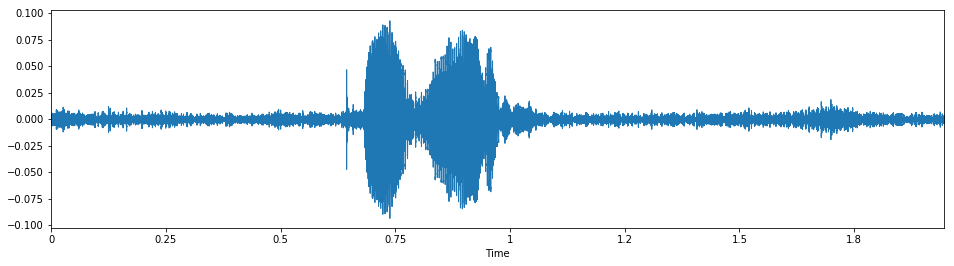

In [10]:
# Test Input Audio
print('Train_A has %d audio waveforms, in folder %s' %(np.shape(wavs_A)[0], train_A_dir))
print('Train_B has %d audio waveforms, in folder %s' %(np.shape(wavs_B)[0], train_B_dir))
idx = 0
x = wavs_A[idx]
print('Audio file index[%d] in Train_A, %d frames, frame rate %d, audio length %.3f seconds' %(idx, np.shape(x)[0], sampling_rate, np.shape(x)[0]/sampling_rate))
librosa.display.waveplot(x, sr=sampling_rate)
Audio(x, rate=sampling_rate)

In [11]:
# Try on 7 audio waveforms each
wavs_A = wavs_A[:7]
wavs_B = wavs_B[:7]

In [12]:
# Extract Pitch contour (f0s), Harmonic spectral envelope (sps), Aperiodic spectral envelope (aps)
f0s_A, timeaxes_A, sps_A, aps_A, coded_sps_A = world_encode_data(wavs = wavs_A, fs = sampling_rate, frame_period = frame_period, coded_dim = num_mcep)
f0s_B, timeaxes_B, sps_B, aps_B, coded_sps_B = world_encode_data(wavs = wavs_B, fs = sampling_rate, frame_period = frame_period, coded_dim = num_mcep)

In [13]:
# f0s: prepare for log Gaussian Normalized Transform 
log_f0s_mean_A, log_f0s_std_A = logf0_statistics(f0s_A)
log_f0s_mean_B, log_f0s_std_B = logf0_statistics(f0s_B)
print('log f0 of Pitch A: Mean %f, Std %f' %(log_f0s_mean_A, log_f0s_std_A))
print('log f0 of Pitch B: Mean %f, Std %f' %(log_f0s_mean_B, log_f0s_std_B))

log f0 of Pitch A: Mean 5.371252, Std 0.252734
log f0 of Pitch B: Mean 5.534919, Std 0.390336


In [14]:
# sps: normalization
coded_sps_A_transposed = transpose_in_list(lst = coded_sps_A)
coded_sps_B_transposed = transpose_in_list(lst = coded_sps_B)
coded_sps_A_norm, coded_sps_A_mean, coded_sps_A_std = coded_sps_normalization_fit_transoform(coded_sps = coded_sps_A_transposed)
coded_sps_B_norm, coded_sps_B_mean, coded_sps_B_std = coded_sps_normalization_fit_transoform(coded_sps = coded_sps_B_transposed)
print("f0s_A: (%d,%d), f0s_B: (%d,%d), coded_sps_A_norm: (%d,%d,%d), coded_sps_B_norm: (%d,%d,%d)" %(len(f0s_A), len(f0s_A[0]), len(f0s_B), len(f0s_B[0]), len(coded_sps_A_norm), np.shape(coded_sps_A_norm[0])[0], np.shape(coded_sps_A_norm[0])[1], len(coded_sps_B_norm), np.shape(coded_sps_B_norm[0])[0], np.shape(coded_sps_B_norm[0])[1]))

f0s_A: (7,390), f0s_B: (7,585), coded_sps_A_norm: (7,24,390), coded_sps_B_norm: (7,24,585)


In [15]:
pool_A, pool_B, f0sA, f0sB  = list(coded_sps_A_norm), list(coded_sps_B_norm), list(f0s_A), list(f0s_B)
# dataset_A, dataset_B = sample_train_data(pool_A=pool_A, pool_B=pool_B, n_frames=n_frames, max_samples=1000)
dataset_A, dataset_B = sample_train_data02(pool_A=pool_A, pool_B=pool_B, f0s_A=f0sA, f0s_B=f0sB, n_frames=n_frames, max_samples=1000)
print('Input data fixed: dataset_A', np.shape(dataset_A), 'dataset_B', np.shape(dataset_B))
print('Note: The first dimension is randomly chosen, ~= 3-4 times of the .wav files')

Input data fixed: dataset_A (20, 24, 128) dataset_B (20, 24, 128)
Note: The first dimension is randomly chosen, ~= 3-4 times of the .wav files


### Autoencoder: Style_Encoder, Content_Encoder, MLP, Decoder, discriminator

In [16]:
def Style_Encoder(inputs, style_dim=16, reuse=False, scope='style_encoder'):                                                            # [1, 24, 128] = [batch_size, feature_channel, time]

    inputs = tf.transpose(inputs, perm=[0, 2, 1], name='input_transpose')                                                               # [1, 128, 24] = [batch_size, time, feature_channel]

    with tf.variable_scope(scope, reuse=reuse):

        h1 = conv1d_layer(inputs=inputs, filters=128, kernel_size=15, strides=1, name='h1_conv')                                        # [1, 128, 128]
        h1_gates = conv1d_layer(inputs=inputs, filters=128, kernel_size=15, strides=1, name='h1_conv_gates')
        h1_glu = gated_linear_layer(inputs=h1, gates=h1_gates, name='h1_glu')

        # Downsample
        d1 = downsample1d_block_withoutIN(inputs=h1_glu, filters=256, kernel_size=5, strides=2, name_prefix='downsample1d_block1')      # [1, 64, 256]
        d2 = downsample1d_block_withoutIN(inputs=d1, filters=512, kernel_size=5, strides=2, name_prefix='downsample1d_block2')          # [1, 32, 512]

        d3 = downsample1d_block_withoutIN(inputs=d2, filters=512, kernel_size=3, strides=2, name_prefix='downsample1d_block3')          # [1, 16, 512]
        d4 = downsample1d_block_withoutIN(inputs=d3, filters=512, kernel_size=3, strides=2, name_prefix='downsample1d_block4')          # [1, 8, 512]

        # Global Average Pooling
        p1 = adaptive_avg_pooling(d4)                                                                                                   # [1, 1, 512]
        style = conv1d_layer(inputs=p1, filters=style_dim, kernel_size=1, strides=1, name='SE_logit')                                   # [1, 1, 16]

        return style                                                                                                                    # [1, 1, 16]


def Content_Encoder(inputs, reuse=False, scope='content_encoder'):
    # IN removes the original feature mean and variance that represent important style information
    inputs = tf.transpose(inputs, perm=[0, 2, 1], name='input_transpose')                                                               # [1, 24, 128] = [batch_size, time, feature_channel]

    with tf.variable_scope(scope, reuse=reuse):

        h1 = conv1d_layer(inputs=inputs, filters=128, kernel_size=15, strides=1, name='h1_conv')                                        # [1, 128, 128]
        h1_norm = instance_norm_layer(inputs=h1, name='h1_norm')
        h1_gates = conv1d_layer(inputs=inputs, filters=128, kernel_size=15, strides=1, name='h1_gates')
        h1_norm_gates = instance_norm_layer(inputs=h1_gates, name='h1_norm_gates')
        h1_glu = gated_linear_layer(inputs=h1_norm, gates=h1_norm_gates, name='h1_glu')

        # downsample
        d1 = downsample1d_block(inputs=h1_glu, filters=256, kernel_size=5, strides=2, name_prefix='downsample1d_block1')                # [1, 64, 256]
        d2 = downsample1d_block(inputs=d1, filters=512, kernel_size=5, strides=2, name_prefix='downsample1d_block2')                    # [1, 32, 512]
               
        # Residual blocks
        r1 = residual1d_block(inputs=d2, filters = 512, kernel_size=3, strides=1, name_prefix='residual1d_block1')                      # [1, 32, 512]
        r2 = residual1d_block(inputs=r1, filters = 512, kernel_size=3, strides=1, name_prefix='residual1d_block2')
        r3 = residual1d_block(inputs=r2, filters = 512, kernel_size=3, strides=1, name_prefix='residual1d_block3')
        content = residual1d_block(inputs=r3, filters=512, kernel_size=3, strides=1, name_prefix='residual1d_block4')

        return content                                                                                                                  # [1, 32, 512]


def MLP(style, reuse=False, scope='MLP'):                                                                                               # [1, 1, 16]

    with tf.variable_scope(scope, reuse=reuse):

        x1 = linear(style, 512, scope='linear_1')                                                                                       # [1, 1, 512]
        x1_gates = linear(x1, 512, scope='linear_1_gates')
        x1_glu = gated_linear_layer(inputs=x1, gates=x1_gates, name='x1_glu')

        x2 = linear(x1_glu, 512, scope='linear_2')
        x2_gates = linear(x2, 512, scope='linear_2_gates')
        x2_glu = gated_linear_layer(inputs=x2, gates=x2_gates, name='x2_glu')

        mu = linear(x2_glu, 512, scope='mu')
        sigma = linear(x2_glu, 512, scope='sigma')

        mu = tf.reshape(mu, shape=[-1, 1, 512])                                                                                         # [1, 1, 512]
        sigma = tf.reshape(sigma, shape=[-1, 1, 512])                                                                                   # [1, 1, 512]

        return mu, sigma                                                                                                                # [1, 1, 512]


def Decoder(content, style, reuse=False, scope="decoder"):

    with tf.variable_scope(scope, reuse=reuse):

        mu, sigma = MLP(style, reuse)                                                                                                   # [1, 1, 512]
        x = content                                                                                                                     # [1, 32, 512]

        # Adaptive Residual blocks
        r1 = residual1d_block_adaptive(inputs=x, filters=512, mu=mu, sigma=sigma, kernel_size=3, strides=1, name_prefix='residual1d_block1')        # [1, 32, 512]
        r2 = residual1d_block_adaptive(inputs=r1, filters=512, mu=mu, sigma=sigma, kernel_size=3, strides=1, name_prefix='residual1d_block2')
        r3 = residual1d_block_adaptive(inputs=r2, filters=512, mu=mu, sigma=sigma, kernel_size=3, strides=1, name_prefix='residual1d_block3')

        # Upsample
        u1 = upsample1d_block(inputs=r3, filters=512, kernel_size=5, strides=1, shuffle_size=2, name_prefix='upsample1d_block1')        # [1, 64, 512]
        u2 = upsample1d_block(inputs=u1, filters=256, kernel_size=5, strides=1, shuffle_size=2, name_prefix='upsample1d_block2')        # [1, 128, 256]

        # Output
        o1 = conv1d_layer(inputs=u2, filters=24, kernel_size=15, strides=1, name='o1_conv')                                             # [1, 128, 24]
        o2 = tf.transpose(o1, perm=[0, 2, 1], name='output_transpose')                                                                  # [1, 24, 128]

        return o2                                                                                                                       # [1, 24, 128] = [batch_size, feature_channel, time]


In [17]:
def Discriminator(inputs, reuse=False, scope='discriminator'):

    # inputs = [batch_size, num_features, time]
    # add channel for 2D convolution [batch_size, num_features, time, 1]
    inputs = tf.expand_dims(inputs, -1)                                                                                                 # [1, 24, 128, 1]

    with tf.variable_scope(scope, reuse=reuse):

        h1 = conv2d_layer(inputs=inputs, filters=128, kernel_size=[3, 3], strides=[1, 2], name='h1_conv')                               # [1, 24, 64, 128]
        h1_gates = conv2d_layer(inputs=inputs, filters=128, kernel_size=[3, 3], strides=[1, 2], name='h1_conv_gates')
        h1_glu = gated_linear_layer(inputs=h1, gates=h1_gates, name='h1_glu')

        # Downsample
        d1 = downsample2d_block(inputs=h1_glu, filters=256, kernel_size=[3, 3], strides=[2, 2], name_prefix='downsample2d_block1')      # [1, 12, 32, 256]
        d2 = downsample2d_block(inputs=d1, filters=512, kernel_size=[3, 3], strides=[2, 2], name_prefix='downsample2d_block2')          # [1, 6, 16, 512]
        d3 = downsample2d_block(inputs=d2, filters=1024, kernel_size=[6, 3], strides=[1, 2], name_prefix='downsample2d_block3')         # [1, 6, 8, 1024]

        # Output
        o1 = tf.layers.dense(inputs=d3, units=1, activation=tf.nn.sigmoid)

        return [o1]                                                                                                                       # [1, 6, 8, 1]


### Try on input data

In [18]:
try_style_a = Style_Encoder(dataset_A[0:1])
try_content_b = Content_Encoder(dataset_B[0:1])
try_x_ab = Decoder(try_content_b, try_style_a)
try_fake_A_logit = discriminator(try_x_ab)

print('try_style_a:', try_style_a)
print(try_content_b)
print(try_x_ab)
print(try_fake_A_logit)

try_style_a: Tensor("style_encoder/SE_logit/BiasAdd:0", shape=(1, 1, 16), dtype=float64)
Tensor("content_encoder/add_3:0", shape=(1, 32, 512), dtype=float64)
Tensor("decoder/output_transpose:0", shape=(?, 24, ?), dtype=float64)
Tensor("discriminator/dense/Sigmoid:0", shape=(?, 6, ?, 1), dtype=float64)


### Autoencoder Model

In [19]:
##################################################################################
# Model
##################################################################################

def Encoder_A(x_A, reuse=False):
    style_A = Style_Encoder(x_A, reuse=reuse, scope='style_encoder_A')
    content_A = Content_Encoder(x_A, reuse=reuse, scope='content_encoder_A')

    return content_A, style_A

def Encoder_B(x_B, reuse=False):
    style_B = Style_Encoder(x_B, reuse=reuse, scope='style_encoder_B')
    content_B = Content_Encoder(x_B, reuse=reuse, scope='content_encoder_B')

    return content_B, style_B

def Decoder_A(content_B, style_A, reuse=False):
    x_ba = Decoder(content=content_B, style=style_A, reuse=reuse, scope='decoder_A')

    return x_ba

def Decoder_B(content_A, style_B, reuse=False):
    x_ab = Decoder(content=content_A, style=style_B, reuse=reuse, scope='decoder_B')

    return x_ab

def discriminate_real(x_A, x_B):
    real_A_logit = Discriminator(x_A, scope="discriminator_A")
    real_B_logit = Discriminator(x_B, scope="discriminator_B")

    return real_A_logit, real_B_logit

def discriminate_fake(x_ba, x_ab):
    fake_A_logit = Discriminator(x_ba, reuse=True, scope="discriminator_A")
    fake_B_logit = Discriminator(x_ab, reuse=True, scope="discriminator_B")

    return fake_A_logit, fake_B_logit

## Module: EmoMUNIT

In [20]:
class EmoMUNIT(object):
    def __init__(self, sess):
        
        self.batch_size = 1
        self.style_dim = 16
        
        self.Encoder_A = Encoder_A
        self.Encoder_B = Encoder_B
        self.Decoder_A = Decoder_A
        self.Decoder_B = Decoder_B
        self.discriminate_real = discriminate_real
        self.discriminate_fake = discriminate_fake
        
        self.recon_x_cyc_w = 0.0
        self.gan_type = 'lsgan'
        
        self.gan_w = 1.0
        
        self.recon_x_w = 10.0
        self.recon_s_w = 1.0
        self.recon_c_w = 1.0
        self.recon_x_cyc_w = 0.0
               
        self.audio_len = 128    # = n_frames, time_length
        self.audio_ch = 24      # = num_mcep, num_features
        
        self.direction = 'A2B'
        
        self.model_name = 'EmoMUNIT'
        self.gan_type = 'lsgan'
        self.dataset_name = 'hap2neu'
        self.log_dir = 'logs'
        self.sample_dir = 'samples'
        self.checkpoint_dir = 'checkpoint'
        self.iteration = 10 # 100000
        
        self.sess = sess
        self.epoch = 3 #10
        self.init_lr = 0.0001
        
        self.print_freq = 1000
        self.save_freq = 1000
        
    
    def build_model(self):
        # tf.reset_default_graph()
        self.lr = tf.placeholder(tf.float32, name='learning_rate')
        
        # Iterate from dataset_A and dataset_B
        self.domain_A = tf.placeholder(tf.float32, shape=[self.batch_size, self.audio_ch, self.audio_len], name='domain_a')
        self.domain_B = tf.placeholder(tf.float32, shape=[self.batch_size, self.audio_ch, self.audio_len], name='domain_b')
    
        self.style_a = tf.placeholder(tf.float32, shape=[self.batch_size, 1, self.style_dim], name='style_a')
        self.style_b = tf.placeholder(tf.float32, shape=[self.batch_size, 1, self.style_dim], name='style_b')  
    
        # encode
        content_a, style_a_prime = self.Encoder_A(self.domain_A)
        content_b, style_b_prime = self.Encoder_B(self.domain_B)

        # decode (within domain)
        x_aa = self.Decoder_A(content_B=content_a, style_A=style_a_prime)
        x_bb = self.Decoder_B(content_A=content_b, style_B=style_b_prime)
    
        # decode (cross domain)
        x_ba = self.Decoder_A(content_B=content_b, style_A=self.style_a, reuse=True)
        x_ab = self.Decoder_B(content_A=content_a, style_B=self.style_b, reuse=True)   
    
        # encode again
        content_b_, style_a_ = self.Encoder_A(x_ba, reuse=True)
        content_a_, style_b_ = self.Encoder_B(x_ab, reuse=True)    
    
        # decode again (if needed)
        if self.recon_x_cyc_w > 0 :
            x_aba = self.Decoder_A(content_B=content_a_, style_A=style_a_prime, reuse=True)
            x_bab = self.Decoder_B(content_A=content_b_, style_B=style_b_prime, reuse=True)

            cyc_recon_A = L1_loss(x_aba, self.domain_A)
            cyc_recon_B = L1_loss(x_bab, self.domain_B)

        else :
            cyc_recon_A = 0.0
            cyc_recon_B = 0.0    
      
        real_A_logit, real_B_logit = self.discriminate_real(self.domain_A, self.domain_B)
        fake_A_logit, fake_B_logit = self.discriminate_fake(x_ba, x_ab)   
    
    
        """ Define Loss """
        # Adversarial Loss
        G_ad_loss_a = generator_loss(self.gan_type, fake_A_logit)
        G_ad_loss_b = generator_loss(self.gan_type, fake_B_logit)
    
        # Discrimination Loss (real/fake)
        D_ad_loss_a = discriminator_loss(self.gan_type, real_A_logit, fake_A_logit)
        D_ad_loss_b = discriminator_loss(self.gan_type, real_B_logit, fake_B_logit)
    
        # Reconstruction Loss
        recon_A = L1_loss(x_aa, self.domain_A) # reconstruction
        recon_B = L1_loss(x_bb, self.domain_B) # reconstruction   
    
        # Semi-CycleGAN Loss
        # For style, encourages diverse outputs given different style codes
        recon_style_A = L1_loss(style_a_, self.style_a)
        recon_style_B = L1_loss(style_b_, self.style_b)
    
        # For content, encourages the translated image to preserve semantic content of the input image
        recon_content_A = L1_loss(content_a_, content_a)
        recon_content_B = L1_loss(content_b_, content_b)   
    
        # Attacker Loss
        Generator_A_loss = self.gan_w * G_ad_loss_a + \
                                   self.recon_x_w * recon_A + \
                                   self.recon_s_w * recon_style_A + \
                                   self.recon_c_w * recon_content_A + \
                                   self.recon_x_cyc_w * cyc_recon_A

        Generator_B_loss = self.gan_w * G_ad_loss_b + \
                           self.recon_x_w * recon_B + \
                           self.recon_s_w * recon_style_B + \
                           self.recon_c_w * recon_content_B + \
                           self.recon_x_cyc_w * cyc_recon_B   
    
        # Defender Loss
        Discriminator_A_loss = self.gan_w * D_ad_loss_a
        Discriminator_B_loss = self.gan_w * D_ad_loss_b
    
        # Total Loss
        self.Generator_loss = Generator_A_loss + Generator_B_loss
        self.Discriminator_loss = Discriminator_A_loss + Discriminator_B_loss
    
    
        """ Training Variables """
        t_vars = tf.trainable_variables()
        G_vars = [var for var in t_vars if 'decoder' in var.name or 'encoder' in var.name]
        D_vars = [var for var in t_vars if 'discriminator' in var.name]
    
        self.G_optim = tf.train.AdamOptimizer(self.lr, beta1=0.5, beta2=0.999).minimize(self.Generator_loss, var_list=G_vars)
        self.D_optim = tf.train.AdamOptimizer(self.lr, beta1=0.5, beta2=0.999).minimize(self.Discriminator_loss, var_list=D_vars)
    
        """" Summary """
        self.all_G_loss = tf.summary.scalar("Generator_loss", self.Generator_loss)
        self.all_D_loss = tf.summary.scalar("Discriminator_loss", self.Discriminator_loss)
        self.G_A_loss = tf.summary.scalar("G_A_loss", Generator_A_loss)
        self.G_B_loss = tf.summary.scalar("G_B_loss", Generator_B_loss)
        self.D_A_loss = tf.summary.scalar("D_A_loss", Discriminator_A_loss)
        self.D_B_loss = tf.summary.scalar("D_B_loss", Discriminator_B_loss)

        self.G_loss = tf.summary.merge([self.G_A_loss, self.G_B_loss, self.all_G_loss])
        self.D_loss = tf.summary.merge([self.D_A_loss, self.D_B_loss, self.all_D_loss])    
    
    
        """ Speech: real and fake """
        self.real_A = self.domain_A
        self.real_B = self.domain_B

        self.fake_A = x_ba
        self.fake_B = x_ab 
    
        """ Test Variables """
        self.test_audio = tf.placeholder(tf.float32, [1, self.audio_ch, self.audio_len], name='test_audio') # [1 24 128]
        self.test_style = tf.placeholder(tf.float32, [1, 1, self.style_dim], name='test_style')             # [1 1 16]

        test_content_a, _ = self.Encoder_A(self.test_audio, reuse=True)
        test_content_b, _ = self.Encoder_B(self.test_audio, reuse=True)

        self.test_fake_A = self.Decoder_A(content_B=test_content_b, style_A=self.test_style, reuse=True)
        self.test_fake_B = self.Decoder_B(content_A=test_content_a, style_B=self.test_style, reuse=True)

        """ Guided Speech Translation """
        self.content_audio = tf.placeholder(tf.float32, [1, self.audio_ch, self.audio_len], name='content_audio')
        self.style_audio = tf.placeholder(tf.float32, [1, self.audio_ch, self.audio_len], name='guide_style_audio_ch')

        if self.direction == 'A2B' :
            guide_content_A, guide_style_A = self.Encoder_A(self.content_audio, reuse=True)
            guide_content_B, guide_style_B = self.Encoder_B(self.style_audio, reuse=True)

        else :
            guide_content_B, guide_style_B = self.Encoder_B(self.content_audio, reuse=True)
            guide_content_A, guide_style_A = self.Encoder_A(self.style_audio, reuse=True)

        self.guide_fake_A = self.Decoder_A(content_B=guide_content_B, style_A=guide_style_A, reuse=True)
        self.guide_fake_B = self.Decoder_B(content_A=guide_content_A, style_B=guide_style_B, reuse=True)
    
    
    
    def train(self):
        # initialize all variables
        tf.global_variables_initializer().run()
        
        # saver to save model
        self.saver = tf.train.Saver()
        
        # summary writer
        self.writer = tf.summary.FileWriter(self.log_dir + '/' + self.model_dir, self.sess.graph)
        
        # restore check-point if it exits
        could_load, checkpoint_counter = self.load(self.checkpoint_dir)
        if could_load:
            start_epoch = (int)(checkpoint_counter / self.iteration)
            start_batch_id = checkpoint_counter - start_epoch * self.iteration
            counter = checkpoint_counter
            print(" [*] Load SUCCESS")
        else:
            start_epoch = 0
            start_batch_id = 0
            counter = 1
            print(" [!] Load FAILED...")
            
        # training loop for epoch
        start_time = time.time()
        for epoch in range(start_epoch, self.epoch):
            
            # new sampling from Train_A, Train_B
            pool_A, pool_B, f0sA, f0sB  = list(coded_sps_A_norm), list(coded_sps_B_norm), list(f0s_A), list(f0s_B)
            dataset_A, dataset_B = sample_train_data02(pool_A=pool_A, pool_B=pool_B, f0s_A=f0sA, f0s_B=f0sB, n_frames=n_frames, max_samples=1000)
            print('Epoch[%d]: Input data sampled: dataset_A' %epoch, np.shape(dataset_A), 'dataset_B', np.shape(dataset_B))

            lr = self.init_lr * pow(0.5, epoch)
            for idx in range(start_batch_id, self.iteration):
                style_a = np.random.normal(loc=0.0, scale=1.0, size=[self.batch_size, 1, self.style_dim])
                style_b = np.random.normal(loc=0.0, scale=1.0, size=[self.batch_size, 1, self.style_dim])
                
                idx_A = idx%len(dataset_A)
                idx_B = idx%len(dataset_B)
                domain_A = dataset_A[idx_A:idx_A+1].astype('float32')
                domain_B = dataset_B[idx_B:idx_B+1].astype('float32')
                
                train_feed_dict = {
                    self.style_a : style_a,
                    self.style_b : style_b,
                    self.lr : lr,
                    self.domain_A : domain_A,
                    self.domain_B : domain_B
                }
                
                # Update D
                _, d_loss, summary_str = self.sess.run([self.D_optim, self.Discriminator_loss, self.D_loss], feed_dict = train_feed_dict)
                self.writer.add_summary(summary_str, counter)
            
                # Update G
                batch_A_audios, batch_B_audios, fake_A, fake_B, _, g_loss, summary_str = \
                self.sess.run([self.real_A, self.real_B, self.fake_A, self.fake_B, self.G_optim, \
                               self.Generator_loss, self.G_loss], feed_dict = train_feed_dict)
                self.writer.add_summary(summary_str, counter)           
            
                # display training status
                counter += 1
                print("Epoch: [%2d] [%6d/%6d] time: %4.4f d_loss: %.8f, g_loss: %.8f" \
                      % (epoch, idx, self.iteration, time.time() - start_time, d_loss, g_loss))
            
                # save test samples
                if np.mod(idx+1, self.print_freq) == 0 :
                    save_audio(batch_A_audios, self.batch_size,
                                './{}/real_A_{:02d}_{:06d}.npy'.format(self.sample_dir, epoch, idx+1))
                    save_audio(batch_B_audios, self.batch_size,
                                './{}/real_B_{}_{:02d}_{:06d}.jpg'.format(self.sample_dir, epoch, idx+1))

                    save_audio(fake_A, self.batch_size,
                                './{}/fake_A_{}_{:02d}_{:06d}.jpg'.format(self.sample_dir, epoch, idx+1))
                    save_audio(fake_B, self.batch_size,
                                './{}/fake_B_{:02d}_{:06d}.npy'.format(self.sample_dir, epoch, idx+1))          
                
                # save checkpoints
                if np.mod(idx+1, self.save_freq) == 0 :
                    self.save(self.checkpoint_dir, counter)
        
            # After an epoch, start_batch_id reset to zero
            # non-zero value is only for the first epoch after loading pre-trained model
            start_batch_id = 0

            # save model for final step
            self.save(self.checkpoint_dir, counter)     
        
        
        
        
    @property
    def model_dir(self):
        return "{}_{}_{}".format(self.model_name, self.dataset_name, self.gan_type)
    
    
    def load(self, checkpoint_dir):
        import re
        print(" [*] Reading checkpoints...")
        checkpoint_dir = os.path.join(checkpoint_dir, self.model_dir)

        ckpt = tf.train.get_checkpoint_state(checkpoint_dir)
        if ckpt and ckpt.model_checkpoint_path:
            ckpt_name = os.path.basename(ckpt.model_checkpoint_path)
            self.saver.restore(self.sess, os.path.join(checkpoint_dir, ckpt_name))
            counter = int(next(re.finditer("(\d+)(?!.*\d)", ckpt_name)).group(0))
            print(" [*] Success to read {}".format(ckpt_name))
            return True, counter
        else:
            print(" [*] Failed to find a checkpoint")
            return False, 0
        
        
    def save(self, checkpoint_dir, step):
        checkpoint_dir = os.path.join(checkpoint_dir, self.model_dir)

        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)

        self.saver.save(self.sess, os.path.join(checkpoint_dir, self.model_name + '.model'), global_step=step)        
        
        
        
        

## Train

In [21]:
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
    gan = EmoMUNIT(sess)
    gan.build_model()
    
    gan.train()
    print(" [*] Training finished!")

 [*] Reading checkpoints...
 [*] Failed to find a checkpoint
 [!] Load FAILED...
Epoch[0]: Input data sampled: dataset_A (18, 24, 128) dataset_B (18, 24, 128)
Epoch: [ 0] [     0/    10] time: 19.7774 d_loss: 1.12324107, g_loss: 27.37199402
Epoch: [ 0] [     1/    10] time: 22.2047 d_loss: 1.06406105, g_loss: 25.41458511
Epoch: [ 0] [     2/    10] time: 24.5163 d_loss: 1.06560206, g_loss: 26.51916504
Epoch: [ 0] [     3/    10] time: 27.1233 d_loss: 1.06233823, g_loss: 29.66050720
Epoch: [ 0] [     4/    10] time: 29.7398 d_loss: 1.03376102, g_loss: 27.54533005
Epoch: [ 0] [     5/    10] time: 32.2534 d_loss: 0.96470636, g_loss: 27.27406311
Epoch: [ 0] [     6/    10] time: 34.7038 d_loss: 0.99513263, g_loss: 27.29193306
Epoch: [ 0] [     7/    10] time: 37.1391 d_loss: 0.92872137, g_loss: 26.49420738
Epoch: [ 0] [     8/    10] time: 39.5693 d_loss: 0.96539527, g_loss: 26.56693459
Epoch: [ 0] [     9/    10] time: 42.2428 d_loss: 0.91255814, g_loss: 27.77939606
Epoch[1]: Input data 